In [22]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [81]:
# Column names (from UCI documentation)
columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", 
    "exang", "oldpeak", "slope", "ca", "thal", "target"
]

df = pd.read_csv("../data/raw/processed.cleveland.data", names=columns)

df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB


In [25]:
# Check for missing values
print(df.isnull().sum())


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [26]:
df.describe(include = object)

,ca,thal
count,303,303
unique,5,4
top,0.0,3.0
freq,176,166


In [83]:
catcols2 = df.select_dtypes( include = ['object']).columns
for col in catcols2:
    unique_vals = df[col].unique()
    print(f"Unique values in '{col}':")
    print(unique_vals)
    print('-' * 40)

Unique values in 'ca':
['0.0' '3.0' '2.0' '1.0' '?']
----------------------------------------
Unique values in 'thal':
['6.0' '3.0' '7.0' '?']
----------------------------------------


In [84]:
print((df == "?").sum()) 

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64


In [85]:
df.replace("?", np.nan, inplace=True)

In [86]:
print((df == "?").sum()) 

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [87]:
df2 = df.copy()

In [88]:
# Fill missing values with mode
for col in ["ca", "thal"]:
    df[col].fillna(df[col].mode()[0], inplace=True)

    
# try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead,

C:\Users\bhava\AppData\Local\Temp\ipykernel_30400\1756980789.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [32]:
df["thal"].value_counts()

thal
3.0    168
7.0    117
6.0     18
Name: count, dtype: int64

C:\Users\bhava\AppData\Local\Temp\ipykernel_30400\2365786561.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df["target"] , palette = "coolwarm")


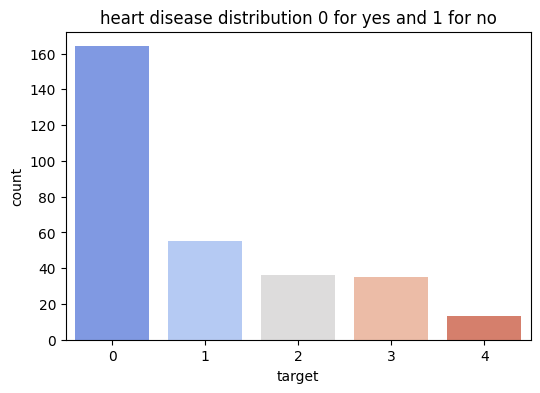

In [33]:
plt.figure(figsize = (6,4))
sns.countplot(x = df["target"] , palette = "coolwarm") 
plt.title("heart disease distribution 0 for yes and 1 for no")
plt.show()

In [34]:
df["target"] = df["target"].apply(lambda x: 1 if x > 0 else 0)

C:\Users\bhava\AppData\Local\Temp\ipykernel_30400\2365786561.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df["target"] , palette = "coolwarm")


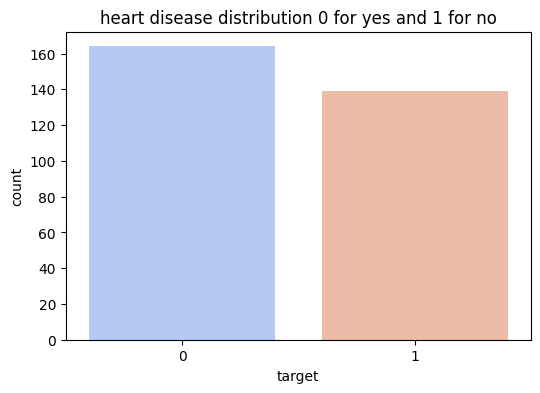

In [35]:
plt.figure(figsize = (6,4))
sns.countplot(x = df["target"] , palette = "coolwarm") 
plt.title("heart disease distribution 0 for yes and 1 for no")
plt.show()

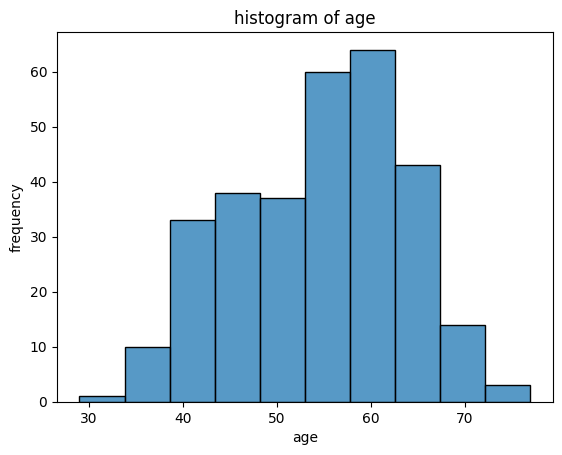

In [11]:
sns.histplot(df['age'], bins=10, kde=False)
plt.xlabel('age')
plt.ylabel('frequency')
plt.title('histogram of age')
plt.show()

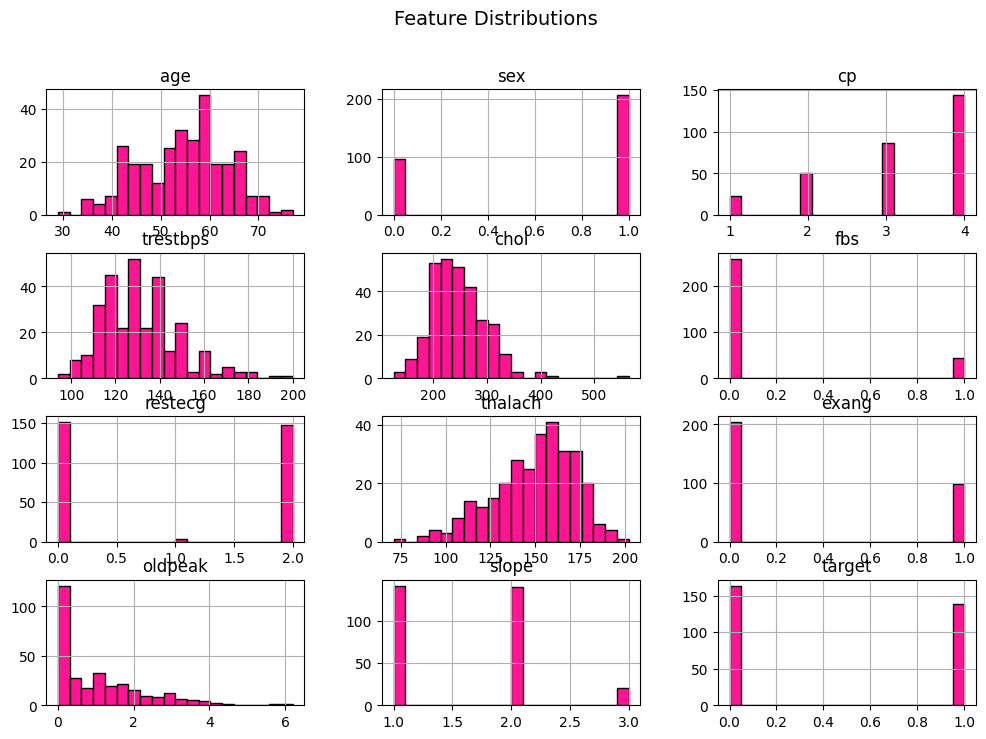

In [36]:
# Histogram for numerical features
df.hist(figsize=(12,8), bins=20, color = "deeppink" ,edgecolor="black")
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()


C:\Users\bhava\AppData\Local\Temp\ipykernel_30400\1406004509.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], data=df, palette="Set2")


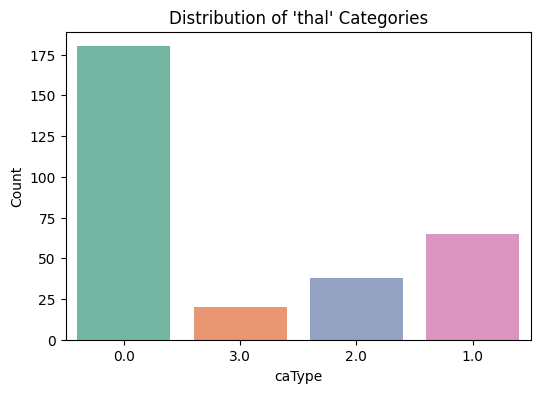

C:\Users\bhava\AppData\Local\Temp\ipykernel_30400\1406004509.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], data=df, palette="Set2")


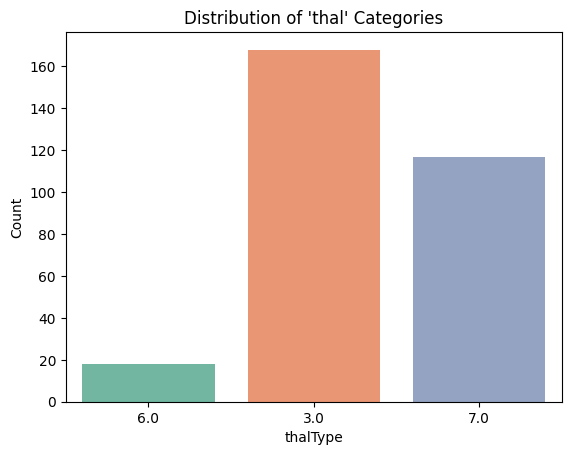

In [37]:
plt.figure(figsize=(6, 4))
for col in ["ca" , "thal"]:
    sns.countplot(x=df[col], data=df, palette="Set2")
    plt.title("Distribution of 'thal' Categories")
    plt.xlabel(col +"Type")
    plt.ylabel("Count")
    plt.show()


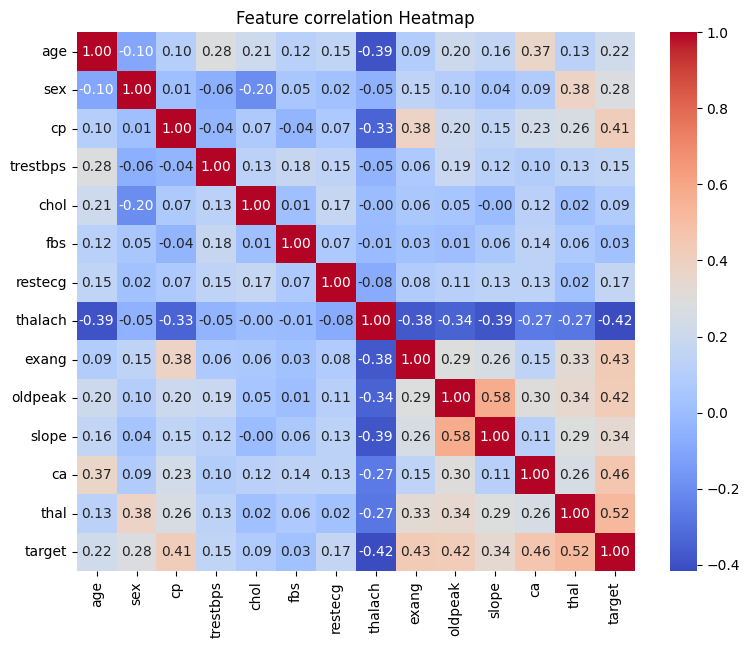

In [38]:
plt.figure(figsize = (9 , 7))
sns.heatmap(df.corr(), cmap = "coolwarm" , annot = True , fmt = ".2f")
plt.title("Feature correlation Heatmap")
plt.show()

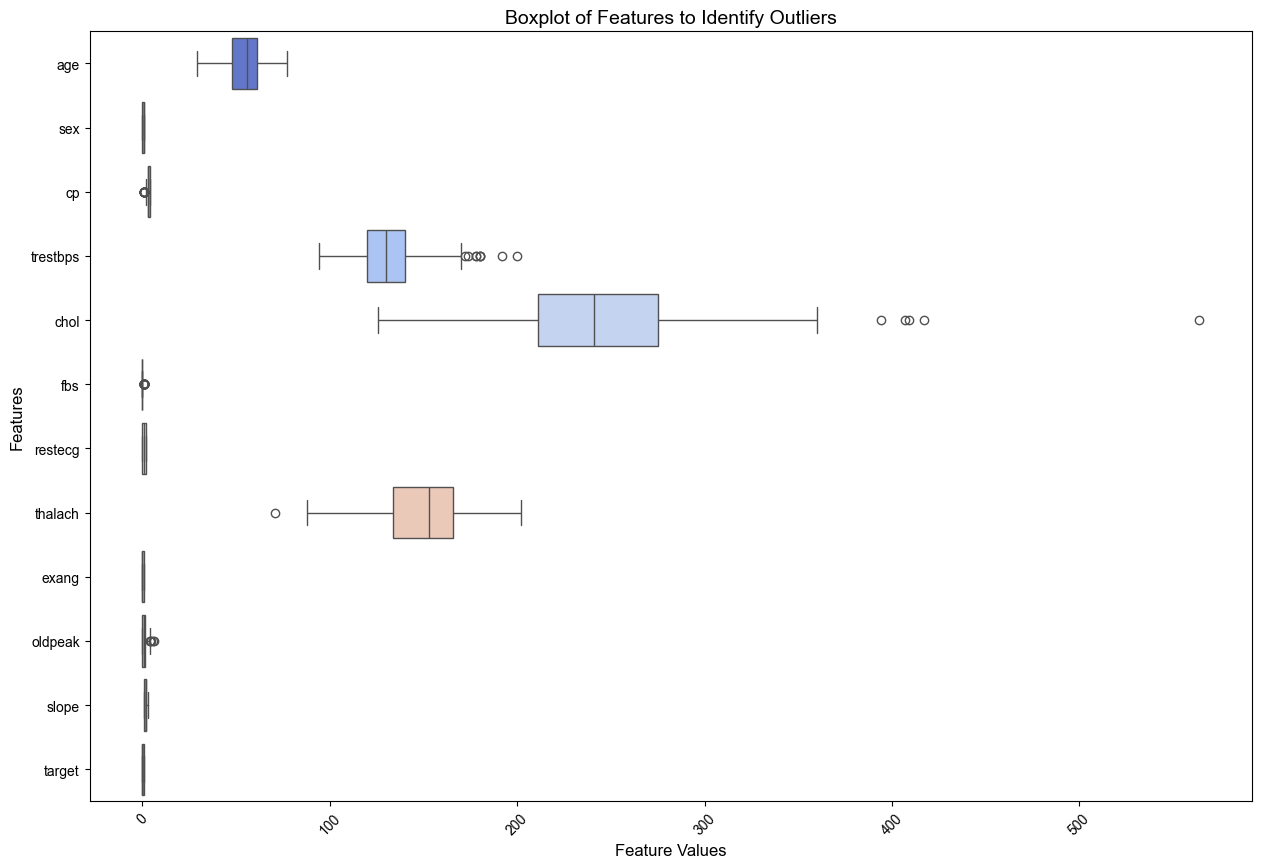

In [18]:
plt.figure(figsize=(15, 10))
# df.boxplot()
plt.xticks(rotation=45)
sns.set_style("whitegrid")
sns.boxplot(data=df, orient="h", palette="coolwarm")
plt.xlabel("Feature Values", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Boxplot of Features to Identify Outliers", fontsize=14)
plt.show()

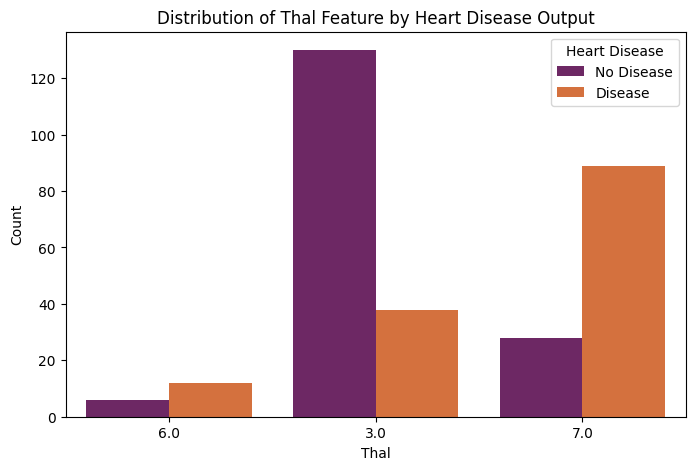

In [41]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='thal', hue='target' ,palette='inferno')
plt.title('Distribution of Thal Feature by Heart Disease Output')
plt.xlabel('Thal')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['No Disease', 'Disease'])
plt.show()

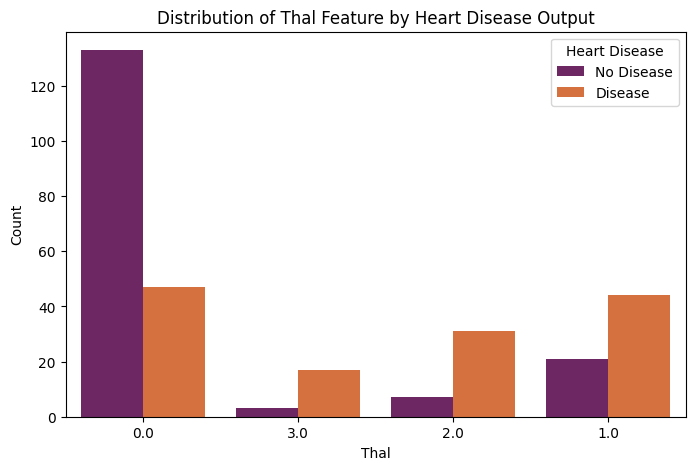

In [42]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='ca', hue='target' ,palette='inferno')
plt.title('Distribution of Thal Feature by Heart Disease Output')
plt.xlabel('Thal')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['No Disease', 'Disease'])
plt.show()

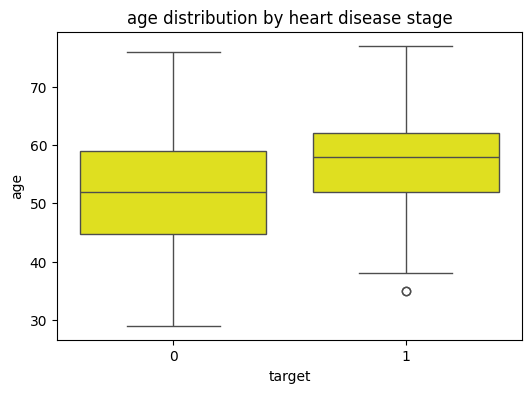

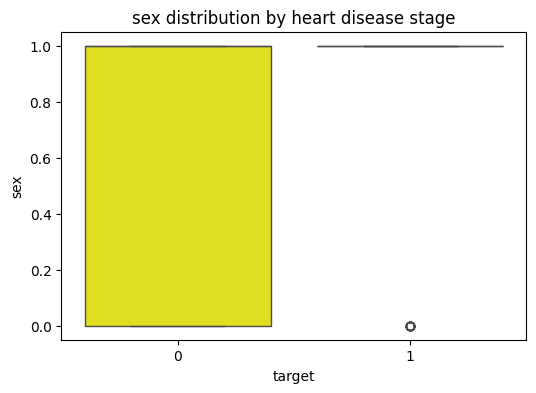

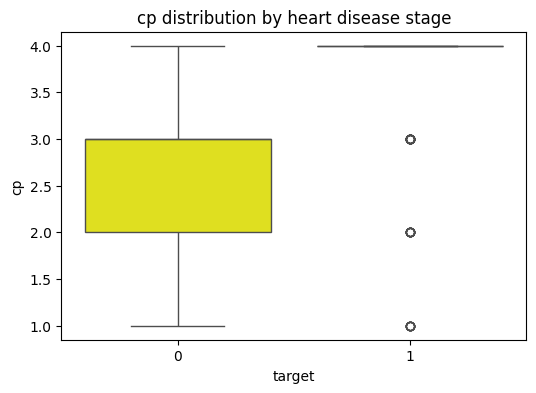

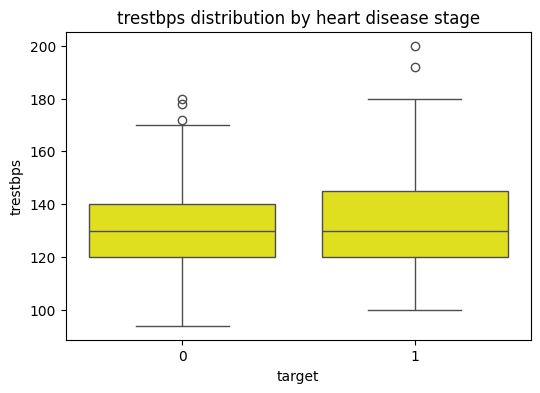

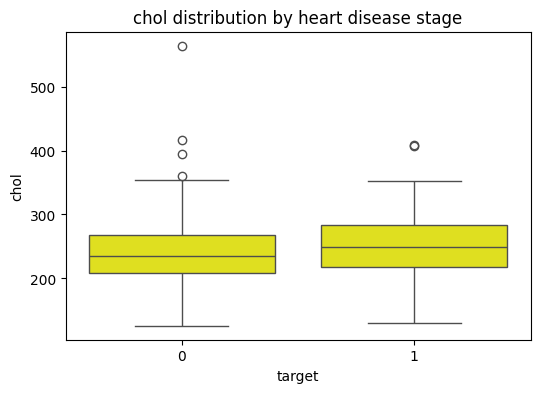

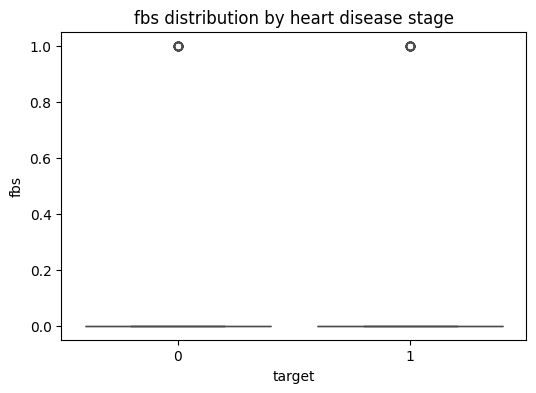

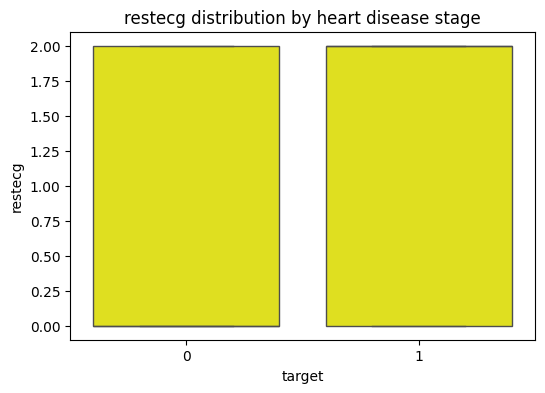

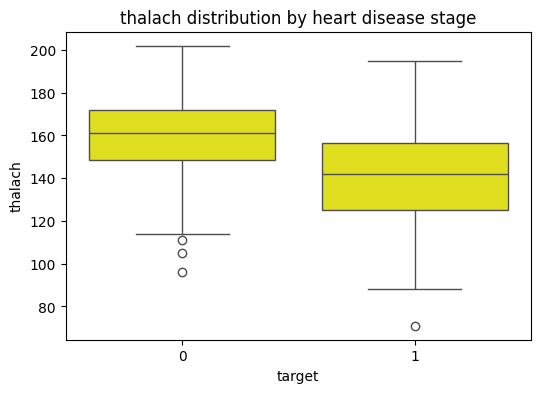

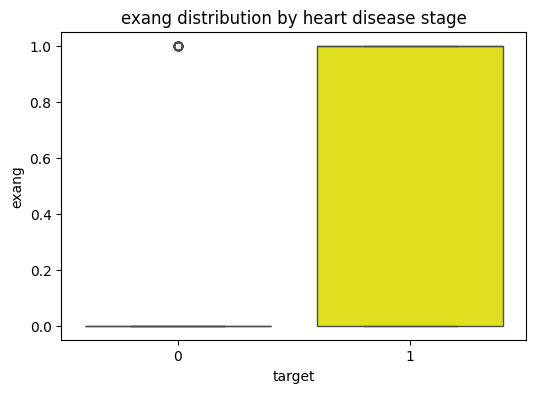

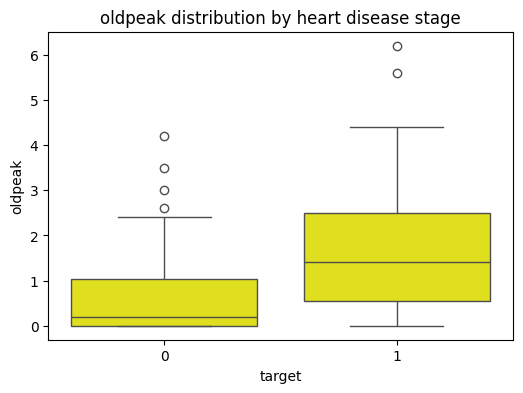

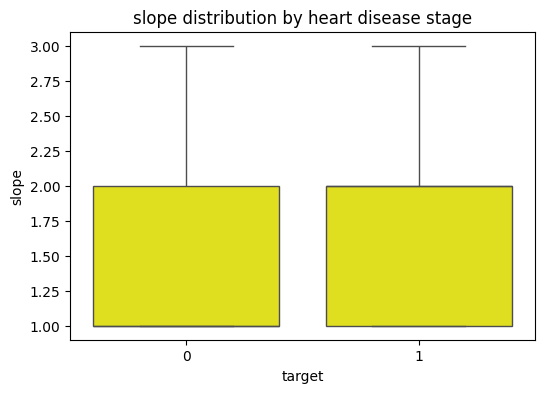

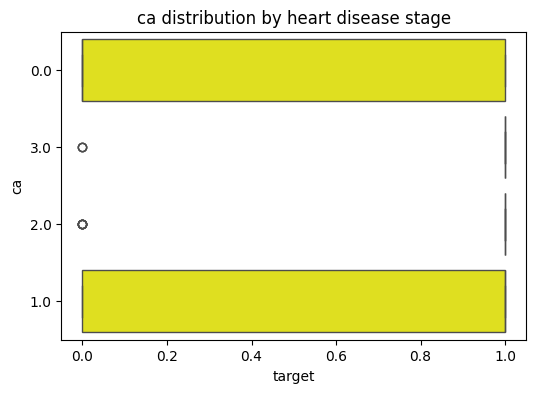

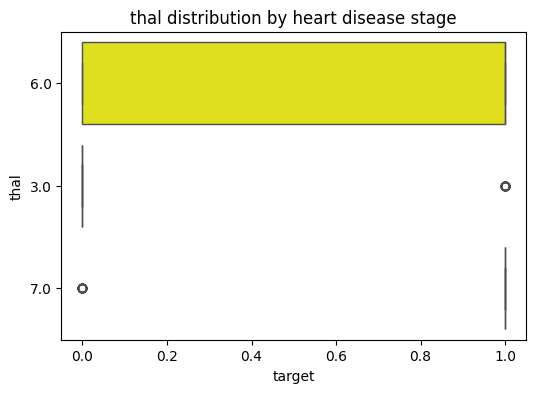

In [48]:
for col in df.columns:
    if col != "target":  # Avoid plotting target against itself
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=df["target"], y=df[col] , color = "yellow")
        plt.title(f"{col} distribution by heart disease stage")
        plt.show()


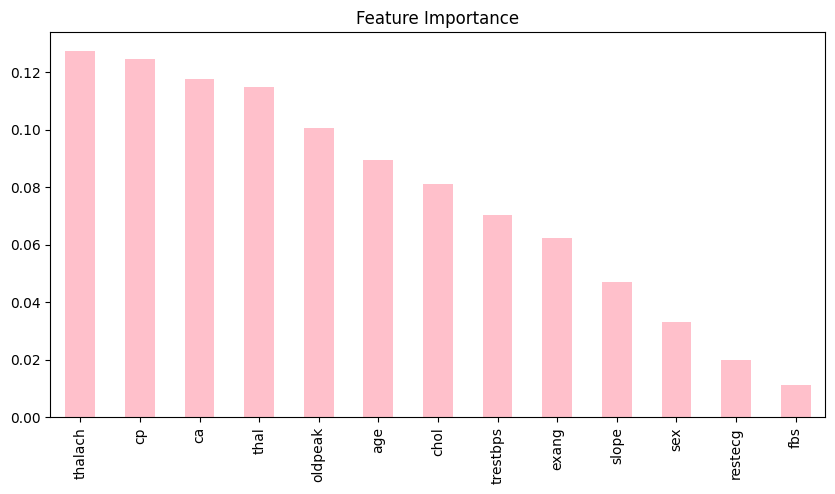

In [49]:
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns=["target"])
y = df["target"]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind="bar", figsize=(10, 5), title="Feature Importance"  , color = 'pink')
plt.show()


In [ ]:
import numpy as np

#to detect outliers using IQR
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)  # First quartile (25th percentile)
    Q3 = np.percentile(data, 75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return data[(data < lower_bound) | (data > upper_bound)]

#checking outliers for numerical feature
for col in df.select_dtypes(include=np.number).columns:
    outliers = detect_outliers_iqr(df[col].dropna())
    print(f"{col}: {len(outliers)} outliers")


age: 0 outliers
sex: 0 outliers
cp: 23 outliers
trestbps: 9 outliers
chol: 5 outliers
fbs: 45 outliers
restecg: 0 outliers
thalach: 1 outliers
exang: 0 outliers
oldpeak: 5 outliers
slope: 0 outliers
target: 0 outliers


In [51]:
print(df['cp'].value_counts())


cp
4.0    144
3.0     86
2.0     50
1.0     23
Name: count, dtype: int64


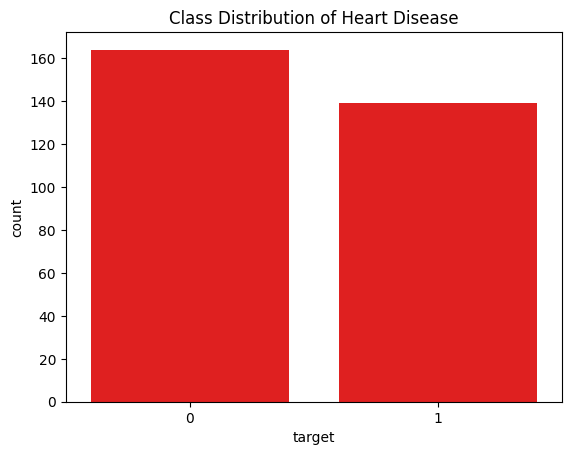

In [53]:
sns.countplot(x=df["target"]  , color= 'red')
plt.title("Class Distribution of Heart Disease")
plt.show()


In [54]:
target = df['target'].value_counts(normalize=True) * 100
print(target)

target
0    54.125413
1    45.874587
Name: proportion, dtype: float64


In [ ]:
from scipy import stats

# Z-scores
z_scores = np.abs(stats.zscore(df.select_dtypes(include=np.number)))

# to find outlires (Z score > 3)
outliers = (z_scores > 3).sum(axis=0)
print("Outlier conts per feature:\n", outliers)


Outlier counts per feature:
 age         0
sex         0
cp          0
trestbps    2
chol        4
fbs         0
restecg     0
thalach     1
exang       0
oldpeak     2
slope       0
target      0
dtype: int64


In [56]:
df.select_dtypes(include=["object"]).head()

,ca,thal
0,0.0,6.0
1,3.0,3.0
2,2.0,7.0
3,0.0,3.0
4,0.0,3.0


In [57]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [58]:
# Convert thal and ca to integer
df['thal'] = df['thal'].astype(float).astype(int)
df['ca'] = df['ca'].astype(float).astype(int)

# one-hot encoding
df = pd.get_dummies(df, columns=['thal', 'ca'], drop_first=True)


In [48]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target,thal_6,thal_7,ca_1,ca_2,ca_3
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0,True,False,False,False,False
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,1,False,False,False,False,True
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,1,False,True,False,True,False
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0,False,False,False,False,False
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0,False,False,False,False,False


In [ ]:
# interaction features using one-hot encoded 'thal' variables
# df['age_ca_1'] = df['age'] * df['ca_1']
# df['age_ca_2'] = df['age'] * df['ca_2']
# df['age_ca_3'] = df['age'] * df['ca_3']
# df['chol_thal_2'] = df['chol'] * df['thal_6'] 
# df['chol_thal_3'] = df['chol'] * df['thal_7']
# df['age_thal_2'] = df['age'] * df['thal_6']
# df['age_thal_3'] = df['age'] * df['thal_7']

# df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,...,ca_1,ca_2,ca_3,age_ca_1,age_ca_2,age_ca_3,chol_thal_2,chol_thal_3,age_thal_2,age_thal_3
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,...,False,False,False,0.0,0.0,0.0,233.0,0.0,63.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,...,False,False,True,0.0,0.0,67.0,0.0,0.0,0.0,0.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,...,False,True,False,0.0,67.0,0.0,0.0,229.0,0.0,67.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,...,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,...,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
from sklearn.preprocessing import OneHotEncoder

cat_features = [ "restecg", "slope" ] #, "thal" , "ca" ]
df = pd.get_dummies(df, columns=cat_features, drop_first=True)


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   thalach      303 non-null    float64
 7   exang        303 non-null    float64
 8   oldpeak      303 non-null    float64
 9   target       303 non-null    int64  
 10  thal_6       303 non-null    bool   
 11  thal_7       303 non-null    bool   
 12  ca_1         303 non-null    bool   
 13  ca_2         303 non-null    bool   
 14  ca_3         303 non-null    bool   
 15  restecg_1.0  303 non-null    bool   
 16  restecg_2.0  303 non-null    bool   
 17  slope_2.0    303 non-null    bool   
 18  slope_3.0    303 non-null    bool   
dtypes: bool(

In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_features = ["age", "chol", "thalach", "trestbps"]  
df[num_features] = scaler.fit_transform(df[num_features])

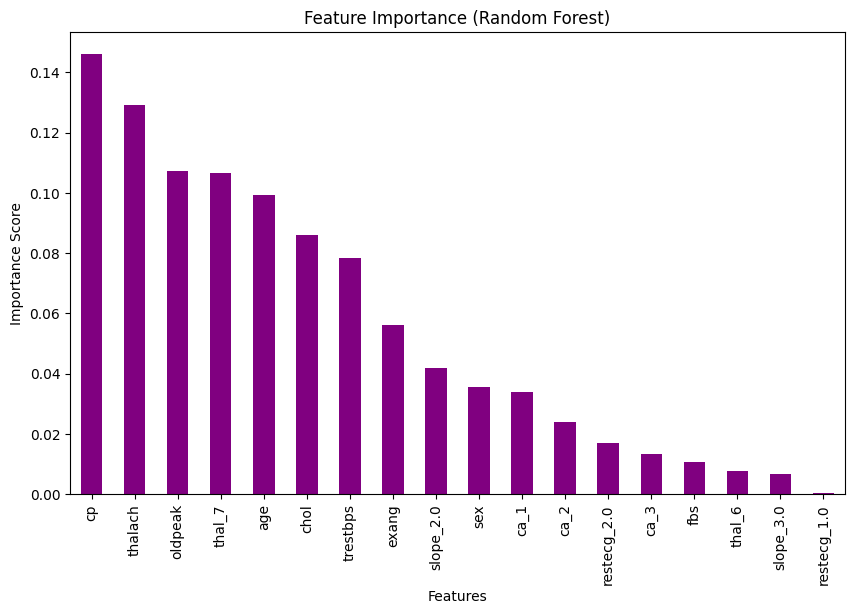

In [62]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define X (features) and y (target)
X = df.drop(columns=["target"]) 
y = df["target"]

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

#feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)

# Sort by importance
feature_importance = feature_importance.sort_values(ascending=False)


plt.figure(figsize=(10, 6))
feature_importance.plot(kind="bar", color="purple")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()


In [65]:
from sklearn.model_selection import train_test_split

X = df.drop(columns =['target'])
y = df['target']
X_train , X_test , y_train , y_test = train_test_split(X, y , random_state = 42 , test_size = 0.20 , stratify = y )


In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)


Accuracy: 0.8852
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.85      0.89        33
           1       0.84      0.93      0.88        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



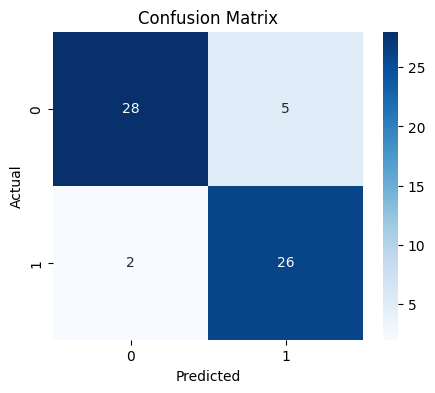

In [67]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

#confsuion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


C:\Users\bhava\AppData\Local\Temp\ipykernel_30400\892460987.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x="Importance", y="Feature", palette="inferno")


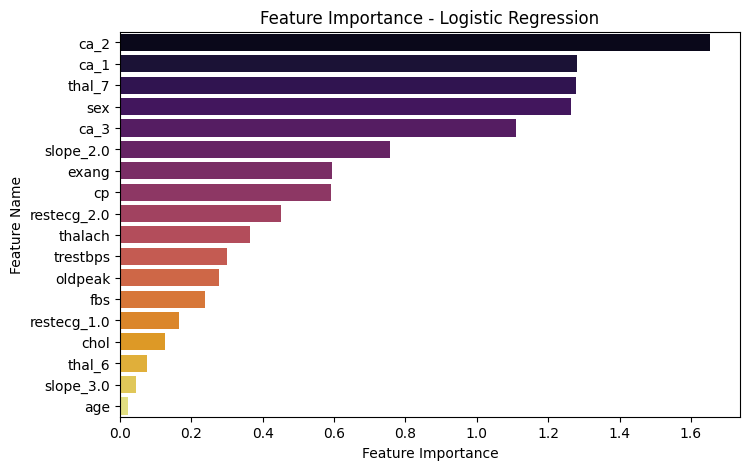

In [69]:
#absolute mean importance across all classes
feature_importance = np.mean(np.abs(model.coef_), axis=0)

importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=importance_df, x="Importance", y="Feature", palette="inferno")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance - Logistic Regression")
plt.show()

In [72]:
df1 = df.drop(columns = ['chol'])

Accuracy: 0.8852
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.85      0.89        33
           1       0.84      0.93      0.88        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



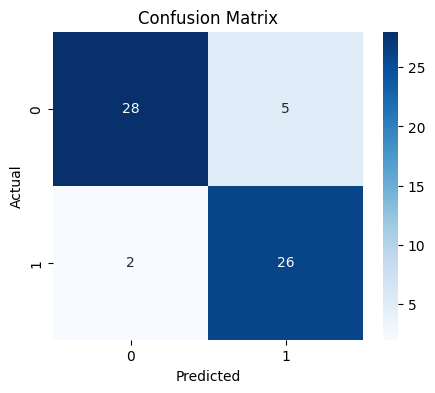

In [73]:
from sklearn.model_selection import train_test_split

X = df1.drop(columns =['target'])
y = df1['target']
X_train , X_test , y_train , y_test = train_test_split(X, y , random_state = 42 , test_size = 0.20 , stratify = y )
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

#confsuion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



In [74]:
# # Creating interaction features
# df['age_ca'] = df['age'] * df['ca']
# df['chol_thal'] = df['chol'] * df['thal']
# df['age_thal'] = df['age'] * df['thal']

# df.head()


In [41]:
!pip install lightgbm 

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
    --------------------------------------- 0.0/1.5 MB 640.0 kB/s eta 0:00:03
   ------- -------------------------------- 0.3/1.5 MB 4.1 MB/s eta 0:00:01
   ---------------------------------------  1.4/1.5 MB 13.0 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 11.5 MB/s eta 0:00:00


In [13]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier()
}

# Train & Evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print(f"{name}: Accuracy = {acc:.2f}")


Logistic Regression: Accuracy = 0.89
Random Forest: Accuracy = 0.89
XGBoost: Accuracy = 0.85
[LightGBM] [Info] Number of positive: 111, number of negative: 131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 236
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458678 -> initscore=-0.165667
[LightGBM] [Info] Start training from score -0.165667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [ ]:
!pip install shap

c:\Users\bhava\Downloads\spotted_python\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


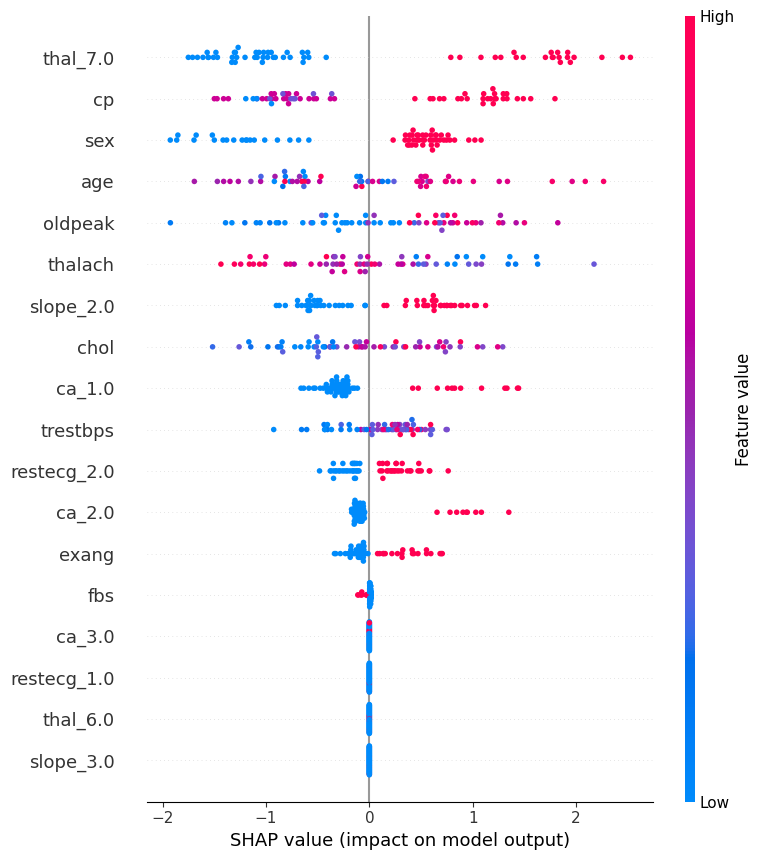

In [14]:
import shap

# Explaining XGBoost Model
explainer = shap.Explainer(models["XGBoost"])
shap_values = explainer(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test)


In [75]:
# import streamlit as st
# import pickle

# model = pickle.load(open("heart_disease_model.pkl", "rb"))

# st.title("Heart Disease Prediction App")
# age = st.number_input("Age", 20, 100)
# chol = st.number_input("Cholesterol Level", 100, 600)
# bp = st.number_input("Blood Pressure",80, 200)

# if st.button("Predict"):
#     prediction = model.predict([[age, chol, bp]])
#     st.write("Prediction: Heart Disease" if prediction[0] == 1 else "No Disease")


In [ ]:
#Saving best model and preprocessing

In [89]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

# Numeric Transformer: Median Imputation + Scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Transformer: Mode Imputation + One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Full Pipeline: Preprocessing + Logistic Regression Model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])



In [90]:
X = df2.drop(columns=['target'])
y = df2['target']

model_pipeline.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'ca', 'thal'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

In [91]:
import pickle

with open("heart_disease_pipeline.pkl", "wb") as file:
    pickle.dump(model_pipeline, file)


In [ ]:
# import pickle

# # Save the trained model
# with open("heart_disease_model.pkl", "wb") as model_file:
#     pickle.dump(models["XGBoost"], model_file)


In [16]:
import streamlit as st
import pickle

# Load trained model
model = pickle.load(open("heart_disease_model.pkl", "rb"))

st.title("Heart Disease Prediction App")
age = st.number_input("Age", min_value=20, max_value=100)
chol = st.number_input("Cholesterol Level", min_value=100, max_value=600)
bp = st.number_input("Blood Pressure", min_value=80, max_value=200)

if st.button("Predict"):
    prediction = model.predict([[age, chol, bp]])
    st.write("Prediction: Heart Disease" if prediction[0] == 1 else "No Disease")


2025-03-20 00:19:53.943 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 00:19:54.670 
  command:

    streamlit run c:\Users\bhava\Downloads\spotted_python\venv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-03-20 00:19:54.686 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 00:19:54.686 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 00:19:54.686 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 00:19:54.686 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 00:19:54.686 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 00:19:54.686 Ses

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression Tuning
log_reg = LogisticRegression(solver='liblinear')  # liblinear supports L1/L2 penalty



log_reg_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2']  # L1 = Lasso, L2 = Ridge
}

grid_log_reg = GridSearchCV(log_reg, log_reg_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_log_reg.fit(X_train, y_train)

print(f"Best Logistic Regression Params: {grid_log_reg.best_params_}")
print(f"Best Logistic Regression Accuracy: {grid_log_reg.best_score_:.4f}")

# Random Forest Tunin
rf = RandomForestClassifier()

rf_params = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}


grid_rf = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print(f"Best Random Forest Params: {grid_rf.best_params_}")
print(f"Best Random Forest Accuracy: {grid_rf.best_score_:.4f}")

# Evaluating on Test Set
best_log_reg = grid_log_reg.best_estimator_
best_rf = grid_rf.best_estimator_

log_reg_test_acc = best_log_reg.score(X_test, y_test)
rf_test_acc = best_rf.score(X_test, y_test)

print(f"Logistic Regression Test Accuracy: {log_reg_test_acc:.4f}")
print(f"Random Forest Test Accuracy: {rf_test_acc:.4f}")


Best Logistic Regression Params: {'C': 10, 'penalty': 'l1'}
Best Logistic Regression Accuracy: 0.8263
Best Random Forest Params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best Random Forest Accuracy: 0.8137
Logistic Regression Test Accuracy: 0.8689
Random Forest Test Accuracy: 0.8852


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# SVM Model - Linear Kernel
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train, y_train)

# Predictions
y_pred_linear = svm_linear.predict(X_test)

# Accuracy
svm_linear_acc = accuracy_score(y_test, y_pred_linear)
print(f"SVM (Linear) Test Accuracy: {svm_linear_acc:.4f}")


SVM (Linear) Test Accuracy: 0.8197


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

#RBF kernel
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Train
svm_rbf.fit(X_train, y_train)

# Predict
y_pred_svm = svm_rbf.predict(X_test)

# Accuracy
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM (RBF Kernel) Test Accuracy: {svm_accuracy:.4f}")


SVM (RBF Kernel) Test Accuracy: 0.8852


100%|██████████| 61/61 [00:29<00:00,  2.08it/s]
C:\Users\bhava\AppData\Local\Temp\ipykernel_20628\2879372901.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


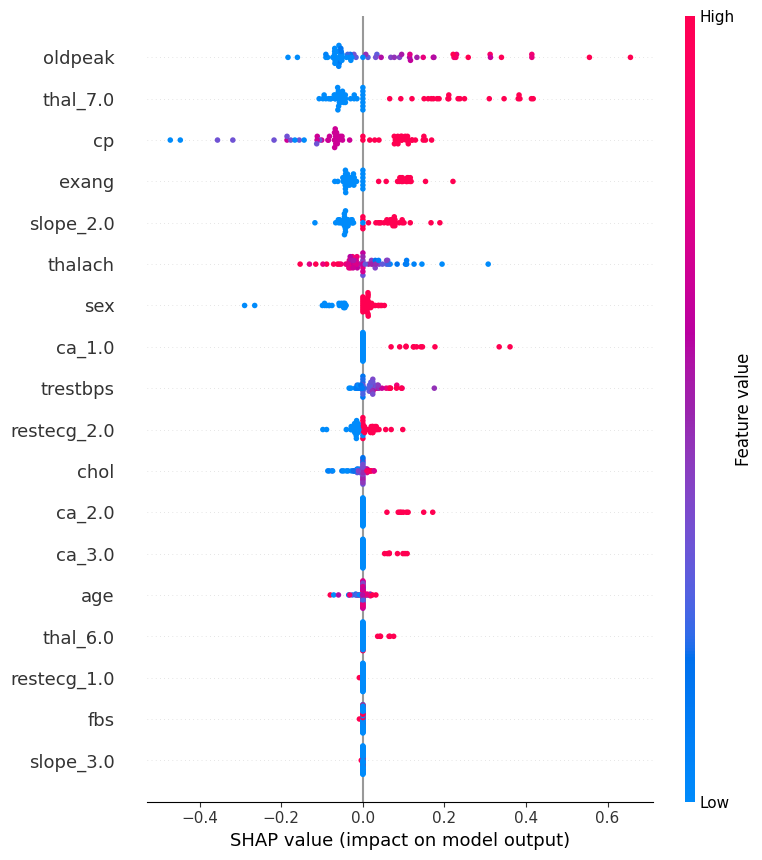

C:\Users\bhava\AppData\Local\Temp\ipykernel_20628\2879372901.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test,  plot_type="bar")


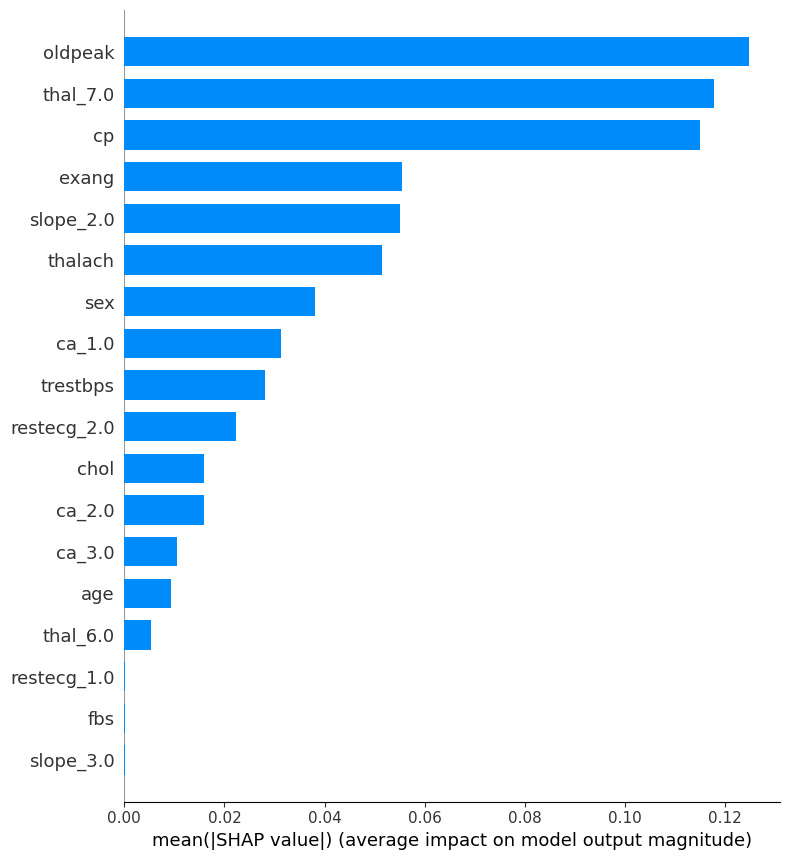

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np

#SHAP KernelExplainer for SVM model
explainer = shap.KernelExplainer(svm_rbf.predict, shap.kmeans(X_train, 10))
shap_values = explainer.shap_values(X_test)

# Summary plot for overall feature impact
shap.summary_plot(shap_values, X_test)

# Bar plot with feature importance ranking
shap.summary_plot(shap_values, X_test,  plot_type="bar")
